# Practice GAN [Generative Adversrial Networks (NIPS 2014)]
- Practice GAN Model
- Training dataset : MNIST (1x28x28)
- Reference : https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/GAN_for_MNIST_Tutorial.ipynb

## Library

In [3]:
!pip3 install torch

In [4]:
!pip3 install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Using cached Pillow-9.4.0-cp310-cp310-macosx_11_0_arm64.whl (3.0 MB)
  Using cached numpy-1.24.1-cp310-cp310-macosx_11_0_arm64.whl (13.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 3.0 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 3.5 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 2.9 MB/s eta 0:00:00 MB/s eta 0:00:01


In [2]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

## 생성자(Generator) 및 판별자(Discriminator) 모델 정의

In [11]:
latent_dim = 100 #?

# Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # 하나의 블록 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                
                # batch normalization 수행 (차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [15]:
# Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1*28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        
        return output

## 학습 데이터셋

In [16]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

## 모델 학습 및 샘플링
- 학습을 위해 생성자와 판변자 모델 초기화
- 적절한 하이퍼 파라미터 설정

In [18]:
# 생성자와 판별자 초기화
generator = Generator()
discriminator = Discriminator()

# generator.cuda() ##
# discriminator.duda() ##

# loss function
adversarial_loss = nn.BCELoss()
# adversarial_loss.cuda() ##

# Learning rate
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [23]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
#         real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
#         fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0
        
        real = torch.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0


#         real_imgs = imgs.cuda()
        real_imgs = imgs
        
        """ 생성자(generator) 학습 """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
#         z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim))

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator 학습 """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/200] [D loss: 0.522556] [G loss: 1.378922] [Elapsed time: 6.46s]
[Epoch 1/200] [D loss: 0.370880] [G loss: 1.184793] [Elapsed time: 12.91s]
[Epoch 2/200] [D loss: 0.326168] [G loss: 1.350001] [Elapsed time: 19.33s]
[Epoch 3/200] [D loss: 0.310015] [G loss: 2.068818] [Elapsed time: 25.75s]
[Epoch 4/200] [D loss: 0.310699] [G loss: 1.226162] [Elapsed time: 32.16s]
[Epoch 5/200] [D loss: 0.287874] [G loss: 2.093414] [Elapsed time: 38.61s]
[Epoch 6/200] [D loss: 0.316905] [G loss: 1.177398] [Elapsed time: 45.03s]
[Epoch 7/200] [D loss: 0.258127] [G loss: 2.219438] [Elapsed time: 51.50s]
[Epoch 8/200] [D loss: 0.144191] [G loss: 2.400687] [Elapsed time: 57.92s]
[Epoch 9/200] [D loss: 0.346631] [G loss: 1.036949] [Elapsed time: 64.36s]
[Epoch 10/200] [D loss: 0.238711] [G loss: 2.099977] [Elapsed time: 70.81s]
[Epoch 11/200] [D loss: 0.357814] [G loss: 3.910855] [Elapsed time: 77.23s]
[Epoch 12/200] [D loss: 0.257929] [G loss: 2.925848] [Elapsed time: 83.67s]
[Epoch 13/200] [D loss:

[Epoch 107/200] [D loss: 0.085052] [G loss: 3.837047] [Elapsed time: 1681.31s]
[Epoch 108/200] [D loss: 0.104484] [G loss: 3.846046] [Elapsed time: 1687.62s]
[Epoch 109/200] [D loss: 0.197673] [G loss: 1.784530] [Elapsed time: 1693.85s]
[Epoch 110/200] [D loss: 0.141122] [G loss: 1.867438] [Elapsed time: 1700.09s]
[Epoch 111/200] [D loss: 0.307303] [G loss: 6.705522] [Elapsed time: 1706.28s]
[Epoch 112/200] [D loss: 0.254479] [G loss: 6.053180] [Elapsed time: 1717.78s]
[Epoch 113/200] [D loss: 0.208702] [G loss: 1.925752] [Elapsed time: 1724.78s]
[Epoch 114/200] [D loss: 0.133095] [G loss: 4.542161] [Elapsed time: 1731.20s]
[Epoch 115/200] [D loss: 0.327648] [G loss: 3.078535] [Elapsed time: 1737.69s]
[Epoch 116/200] [D loss: 0.129024] [G loss: 3.188451] [Elapsed time: 1744.10s]
[Epoch 117/200] [D loss: 0.117319] [G loss: 2.761108] [Elapsed time: 1750.53s]
[Epoch 118/200] [D loss: 0.160091] [G loss: 2.336241] [Elapsed time: 1756.95s]
[Epoch 119/200] [D loss: 0.168369] [G loss: 5.831396

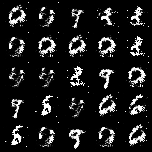

In [26]:
from IPython.display import Image

Image('92000.png')